# Airline Data Modeling - Logistic Regression
___

This will be a classification model intended to predict budget vs. non-budget commercial passenter airlines based on safety data collected from the NSTB aviation accident [database](https://www.ntsb.gov/Pages/AviationQueryV2.aspx). The budget airlines will be the target and assigned as '1'.

Our target metric is accuracy.  We want to correctly predict both budget and non-budget airlines with no preference between false negatives or positives.

Ultimately, we were unsuccessful in try to predict a budget vs. non-budget airline based on data from the NTSB aviation accident database using logistic regression and CountVectorizer. The best one was a Logistic Regression with CountVectorizer which was very overfit and marginally better than our baseline model.  Its testing accuracy was about 81%.

My models were generating errors stating sklearn found unknown categories in columns.  When performing EDA and cleaning, I realized that even after trying to consolidate categories, there were values in several columns that appeared only once.  In hindsight, I would have considered a different way to categorize the feature data, but we will work with this due to time restrictions.  I assumed handle_ignore = 'ignore' would solve this, but I ended up having to ignore the warnings.

## Contents
---
- [Data Cleaning & Setting Target](#Data-Cleaning-&-Setting-Target)
- [Train/Test/Split & Base Model](#Train/Test/Split-&-Base-Model)
- [Feature Engineering](#Feature-Engineering)
- [Modeling](#Modeling)
- [Predictions and Metrics](#Predictions-and-Metrics)
- [PCA](#PCA)
- [Simplier Logistic Regression Model](#Simplier-Logistic-Regression-Model)
- [Just For Fun - Aircraft Make & Airline](#Just-For-Fun---Aircraft-Make-&-Airline)

### Data Prepping & Setting Target
___

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(24)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, RocCurveDisplay

import warnings
warnings.filterwarnings("ignore", message="Found unknown categories in columns")

#### Budget Airlines (Target)

* Alaska
* Frontier
* JetBlue
* Allegiant
* Spirit
* Sun Country
* Southwest

#### Non-Budget Airlines

* American
* United
* Delta
* US Airways 
* Continental
* Hawaiian

Note: US Airways merged with American and Continental merged with United.

Read in and drop columns we won't need for modeling.  Kept tail number and lat/long for research purposes only.  Tail number is great for looking up plane models.


In [2]:
airlines_df = pd.read_csv('../data/text_processed_aviation_data.csv')

In [3]:
airlines_df.columns

Index(['event_type', 'event_date', 'tail_number', 'highest_injury_level',
       'fatal_injury_count', 'serious_injury_count', 'minor_injury_count',
       'probable_cause', 'latitude', 'longitude', 'airport_id', 'operator',
       'make', 'aircraft_damage', 'model'],
      dtype='object')

In [4]:
columns_to_drop = ['tail_number', 'event_date', 'latitude', 'longitude']

In [5]:
airlines_df.drop(columns = columns_to_drop, inplace = True)

In [6]:
airlines_df['operator'].value_counts()

operator
american       129
delta          102
united          89
southwest       62
continental     54
us airways      52
alaska          22
frontier        15
jetblue         11
hawaiian         7
allegiant        6
spirit           5
sun country      4
Name: count, dtype: int64

Binarize the budget and non-budget airlines.

In [7]:
targets = {'american':0,
              'delta':0,
              'united':0,
              'southwest':1,
              'continental':0,
              'us airways':0,
              'alaska':1,
              'frontier':1,
              'jetblue':1,
              'hawaiian':0,
              'allegiant':1,
              'spirit':1,
              'sun country':1
             }

airlines_df['operator'] = airlines_df['operator'].replace(targets)

In [8]:
# Note that the values should be stratified for modeling as they are uneven.
airlines_df['operator'].value_counts()

operator
0    433
1    125
Name: count, dtype: int64

### Train/Test/Split & Base Model
___

In [9]:
# Set X and y
X = airlines_df.drop(columns = 'operator')
y = airlines_df['operator']

In [10]:
# Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=24,
                                                   stratify=y)  

**What is the base model?**
* There is a **78%** chance of correctly predicting a non-budget airline.

In [11]:
y_train.value_counts(normalize = True)

operator
0    0.77512
1    0.22488
Name: proportion, dtype: float64

In [12]:
#Ensuring that stratify is maintaining the skew between the types of airlines.
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(operator
 0    0.77512
 1    0.22488
 Name: proportion, dtype: float64,
 operator
 0    0.778571
 1    0.221429
 Name: proportion, dtype: float64)

### Feature Engineering
___

All of the columns in the dataset are categorical except for the fatal/serious/minor injury counts.  Therefore, they shall be one-hot encoded. We will use a standard scaler on the injury counts only.  I am not sure if the highest_injury_count column is helpful when pair with quantitative injury counts. Possibly something to explore given time.

A note about the 'reportunavailable' placeholder.  According to the CountVectorizer documentation, if no stop word list is used, setting the max_df value to a range of 0.7- 1.0 can detect and filter out stop words.  I've already used stopwords in SpaCy, so will try to keep this in mind while modeling.
[Reference Website](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [13]:
#Set up a column transformer

ohe_columns = ['event_type', 'highest_injury_level', 'airport_id', 'make', 'aircraft_damage', 'model']
ss_columns = ['fatal_injury_count','serious_injury_count', 'minor_injury_count']


ctx = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns),
    ('sc', StandardScaler(), ss_columns),
    ('cvec', CountVectorizer(), 'probable_cause')
], remainder='passthrough', verbose_feature_names_out=False)


### Modeling
___

As always, a wide variety of parameters were tested.  Liblinear was chosen due to convergence errors. Below are the best settings.

In [14]:
pipe_params = {
    'ctx__cvec__max_features': [200],
    'ctx__cvec__min_df': [3],
    'ctx__cvec__max_df': [0.90],
    'ctx__cvec__ngram_range': [(1,3)],
    'lr__C': [10],
    'lr__penalty': ['l2'],
    'lr__solver': ['liblinear']
}

In [15]:
pipe = Pipeline([
    ('ctx', ctx),
    ('lr', LogisticRegression())
])


In [16]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5)

In [17]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ctx',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['event_type',
                                                                          'highest_injury_level',
                                                                          'airport_id',
                                                                          'make',
                                                                          'aircraft_damage',
                                                                          'model']),
                                                                        ('sc',
                                                                         StandardScaler(),
                                                                         ['fatal_injury_count',
                                                                          'serious_injury_count',
                                                                          'minor_injury_count']),
                                                                        ('cvec',
                                                                         CountVectorizer(),
                                                                         'probable_cause')],
                                                          verbose_feature_names_out=False)),
                                       ('lr', LogisticRegression())]),
             param_grid={'ctx__cvec__max_df': [0.9],
                         'ctx__cvec__max_features': [200],
                         'ctx__cvec__min_df': [3],
                         'ctx__cvec__ngram_range': [(1, 3)], 'lr__C': [10],
                         'lr__penalty': ['l2'], 'lr__solver': ['liblinear']})

In [18]:
gs.score(X_train, y_train)

0.9952153110047847

In [19]:
gs.score(X_test, y_test)

0.8142857142857143

81% is higher than baseline model of 78%, butthe model is extremely overfit.

In [20]:
#What was the best score?
print(f'The best accuracy score in all models tested in grid search is {round(gs.best_score_* 100,2)}%')

The best accuracy score in all models tested in grid search is 78.01%


In [21]:
# Breakdown of the parameters chosen to make the best model.
gs.best_params_

{'ctx__cvec__max_df': 0.9,
 'ctx__cvec__max_features': 200,
 'ctx__cvec__min_df': 3,
 'ctx__cvec__ngram_range': (1, 3),
 'lr__C': 10,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear'}

### Predictions and Metrics
___

In [22]:
#Training set results
print(f'Training accuracy score is at {round(gs.score(X_train, y_train)* 100,2)}%')

Training accuracy score is at 99.52%


In [23]:
# Testing set results is at 72% - Null model is at 77%, so this model
# is unable to predict airline based on safety data.
print(f'Testing accuracy score is at {round(gs.score(X_test, y_test)* 100,2)}%')

Testing accuracy score is at 81.43%


In [24]:
# Calculating model predictions (budget airlines = 1 and non-budget = 0)
# and the probability of each raw value.
pred = gs.predict(X_test)
pred[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
      dtype=int64)

In [25]:
# Accuracy Score - What precentage of total predictions were correct?
print(f'This model has an accuracy score of {round(metrics.accuracy_score(y_test, pred) * 100,2)}%')

This model has an accuracy score of 81.43%


In [26]:
gs.predict_proba(X_test)[:20]

array([[9.99999682e-01, 3.17780129e-07],
       [9.82589895e-01, 1.74101051e-02],
       [9.91873547e-01, 8.12645303e-03],
       [9.99922294e-01, 7.77064036e-05],
       [9.50208272e-01, 4.97917281e-02],
       [9.84747837e-01, 1.52521627e-02],
       [9.64073954e-01, 3.59260463e-02],
       [9.34422895e-01, 6.55771051e-02],
       [9.93846911e-01, 6.15308913e-03],
       [8.80572534e-01, 1.19427466e-01],
       [7.24509805e-01, 2.75490195e-01],
       [2.17480714e-01, 7.82519286e-01],
       [9.95328140e-01, 4.67186032e-03],
       [1.20819649e-01, 8.79180351e-01],
       [8.21154985e-01, 1.78845015e-01],
       [4.37384606e-02, 9.56261539e-01],
       [9.98154821e-01, 1.84517856e-03],
       [9.64154117e-01, 3.58458830e-02],
       [9.87357848e-01, 1.26421516e-02],
       [9.81008857e-01, 1.89911432e-02]])

#### Confusion Matrix
___

As this model is slightly better than the baseline and despite that is is very overfit, we'll check out its metrics.

In [27]:
cm = confusion_matrix(y_test, pred)
cm

array([[99, 10],
       [16, 15]], dtype=int64)

#### Confusion Dataframe

In [28]:
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

99 10 16 15


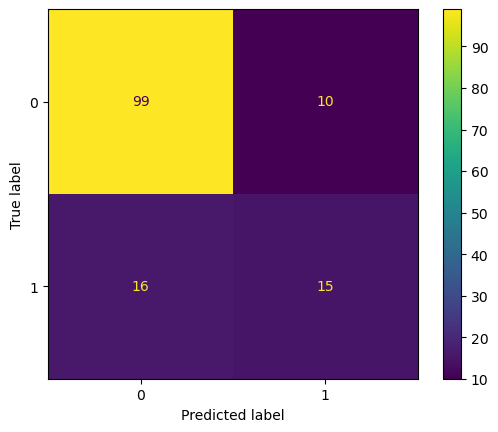

In [29]:
cmd = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = gs.classes_)

cmd.plot()
plt.savefig('../images/logreg_cvec_confusion_matrix_display_kh', dpi = 192);

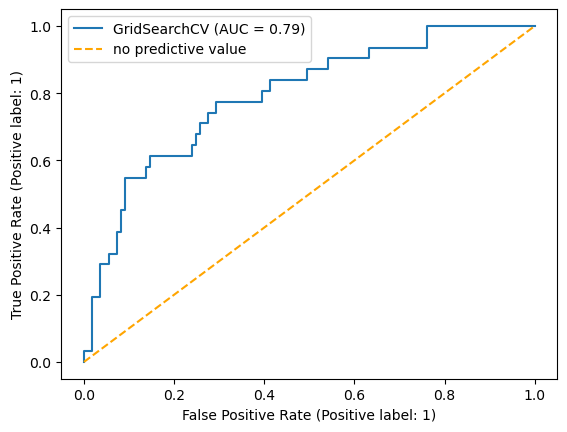

In [30]:
# most current method in scikit-learn is RocCurveDisplay
# Yikes
RocCurveDisplay.from_estimator(gs, X_test, y_test)

# add 'worst case scenario' line
plt.plot([0,1], [0,1],
         label = 'no predictive value',
         linestyle = '--',
         color = 'orange')

# add a legend
plt.legend();

In [31]:
#Recall / Sensitivity
metrics.recall_score(y_test, pred)

0.4838709677419355

In [32]:
#Specificity
tn / (tn + fp)

0.908256880733945

In [33]:
# Precision - 60% were correct predicted to be a budget airline
metrics.precision_score(y_test, pred)

0.6

In [34]:
# Accuracy is our most important metric in this project.  This is not much better
# the baseline score ie. randomly guessing.
metrics.accuracy_score(y_test, pred)

0.8142857142857143

In [35]:
# F1 Score - Not great
f1_score(y_test, pred)

0.5357142857142857

In [36]:
# Misclassification Rate.  The oppsite of what we'd like to see.
(fp + fn) / (tp + tn + fp + fn)

0.18571428571428572

### PCA
___

The testing score is the same as the baseline.  Seeing a trend of not being able to create a model that does better than the baseline with respect to predicting budget vs. non-budget airlines using accident data.

In [37]:
#Set up a column transformer#Set up a column transformer

ohe_columns = ['event_type', 'highest_injury_level', 'airport_id', 'make', 'aircraft_damage', 'model']
ss_columns = ['fatal_injury_count','serious_injury_count', 'minor_injury_count']


ctx = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns),
    ('sc', StandardScaler(), ss_columns),
    ('cvec', CountVectorizer(), 'probable_cause')
], remainder='passthrough', verbose_feature_names_out=False)


In [38]:
pipe_params = {
    'ctx__cvec__max_features': [200],
    'ctx__cvec__min_df': [3],
    'ctx__cvec__max_df': [0.90],
    'ctx__cvec__ngram_range': [(1,3)],
    'lr__C': [10],
    'lr__penalty': ['l2'],
    'lr__solver': ['liblinear'],
    'pca__n_components': range(4,41,2)
}

In [39]:
pipe = Pipeline([
    ('ctx', ctx),
    ('pca', PCA()),
    ('lr', LogisticRegression())
])


In [40]:
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  n_jobs = -1)

In [41]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ctx',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['event_type',
                                                                          'highest_injury_level',
                                                                          'airport_id',
                                                                          'make',
                                                                          'aircraft_damage',
                                                                          'model']),
                                                                        ('sc',
                                                                         StandardScaler(),
                                                                         ['fatal_injury_count',
                                                                          'serious_injury_count',
                                                                          'minor_injury_co...
                                                                        ('cvec',
                                                                         CountVectorizer(),
                                                                         'probable_cause')],
                                                          verbose_feature_names_out=False)),
                                       ('pca', PCA()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'ctx__cvec__max_df': [0.9],
                         'ctx__cvec__max_features': [200],
                         'ctx__cvec__min_df': [3],
                         'ctx__cvec__ngram_range': [(1, 3)], 'lr__C': [10],
                         'lr__penalty': ['l2'], 'lr__solver': ['liblinear'],
                         'pca__n_components': range(4, 41, 2)})

In [42]:
gs.best_params_

{'ctx__cvec__max_df': 0.9,
 'ctx__cvec__max_features': 200,
 'ctx__cvec__min_df': 3,
 'ctx__cvec__ngram_range': (1, 3),
 'lr__C': 10,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear',
 'pca__n_components': 10}

In [43]:
#What was the best score?
print(f'The best accuracy score in all models tested in grid search is {round(gs.best_score_* 100,2)}%')

The best accuracy score in all models tested in grid search is 77.76%


In [44]:
#Training set results
print(f'Training accuracy score is at {round(gs.score(X_train, y_train)* 100,2)}%')

Training accuracy score is at 77.75%


In [45]:
# Testing set results is at 74% - Null model is at 78%, so this model
# is unable to predict airline based on safety data.
print(f'Testing accuracy score is at {round(gs.score(X_test, y_test)* 100,2)}%')

Testing accuracy score is at 78.57%


### Simplier Logistic Regression Model
___

Clearly the previous model is overfit and so we'll try to make a model with less features in an attempt to simplify it. Will consider only using highest_injury_level and aircraft_damage.

In [46]:
airlines_df.columns

Index(['event_type', 'highest_injury_level', 'fatal_injury_count',
       'serious_injury_count', 'minor_injury_count', 'probable_cause',
       'airport_id', 'operator', 'make', 'aircraft_damage', 'model'],
      dtype='object')

In [47]:
X = airlines_df[['highest_injury_level','aircraft_damage']]
y = airlines_df['operator']

In [48]:
X
y

0      0
1      0
2      1
3      1
4      1
      ..
553    0
554    0
555    0
556    0
557    0
Name: operator, Length: 558, dtype: int64

In [49]:
# Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   stratify=y)  

In [50]:
y_train.value_counts(normalize = True)

operator
0    0.77512
1    0.22488
Name: proportion, dtype: float64

In [51]:
#Ensuring that stratify is maintaining the slight skew between the types of airlines.
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(operator
 0    0.77512
 1    0.22488
 Name: proportion, dtype: float64,
 operator
 0    0.778571
 1    0.221429
 Name: proportion, dtype: float64)

In [52]:
simple_ohe_columns = ['highest_injury_level', 'aircraft_damage']

ctx = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), simple_ohe_columns),
], remainder='passthrough',
    verbose_feature_names_out = False
)

In [53]:
pipe_params = {
    'lr__C': [0.05],
    'lr__penalty': ['l2'],
    'lr__solver': ['liblinear']
}

In [54]:
pipe = Pipeline([
    ('ctx', ctx),
    ('lr', LogisticRegression())
])


In [55]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5)

In [56]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ctx',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['highest_injury_level',
                                                                          'aircraft_damage'])],
                                                          verbose_feature_names_out=False)),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.05], 'lr__penalty': ['l2'],
                         'lr__solver': ['liblinear']})

In [57]:
gs.score(X_test, y_test)

0.7785714285714286

In [58]:
# This is better than the first logistic regression model, but no better than the baseline.
print(f'The best accuracy score in all models tested in grid search is {round(gs.best_score_* 100,2)}%')

The best accuracy score in all models tested in grid search is 77.51%


In [59]:
# Breakdown of the parameters chosen to make the best model.
gs.best_params_

{'lr__C': 0.05, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

In [60]:
# Calculating model predictions (budget airlines = 1 and non-budget = 0)
# and the probability of each raw value.
pred = gs.predict(X_test)
pred[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [61]:
gs.predict_proba(X_test)[:20]

array([[0.74545421, 0.25454579],
       [0.72442184, 0.27557816],
       [0.76283027, 0.23716973],
       [0.76283027, 0.23716973],
       [0.74545421, 0.25454579],
       [0.71783937, 0.28216063],
       [0.74545421, 0.25454579],
       [0.76283027, 0.23716973],
       [0.76283027, 0.23716973],
       [0.74545421, 0.25454579],
       [0.74545421, 0.25454579],
       [0.74545421, 0.25454579],
       [0.74545421, 0.25454579],
       [0.74545421, 0.25454579],
       [0.73054936, 0.26945064],
       [0.7385956 , 0.2614044 ],
       [0.73151715, 0.26848285],
       [0.76283027, 0.23716973],
       [0.75528284, 0.24471716],
       [0.74545421, 0.25454579]])

In [62]:
# Accuracy Score - This is about the same as the baseline model.
print(f'This model has an accuracy score of {round(metrics.accuracy_score(y_test, pred) * 100,2)}%')

This model has an accuracy score of 77.86%


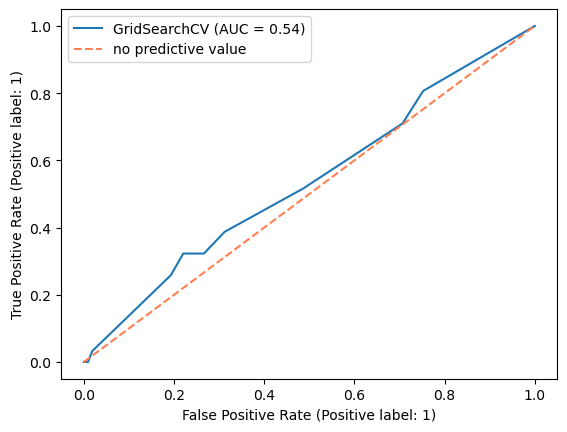

In [63]:
# most current method in scikit-learn is RocCurveDisplay
# Ugh...
RocCurveDisplay.from_estimator(gs, X_test, y_test)

# 'worst case scenario' line
plt.plot([0,1], [0,1],
         label = 'no predictive value',
         linestyle = '--',
         color = 'coral')

# add a legend
plt.legend();

 Even when simplified, the model score doesn't do better than the baseline.  Other notebooks will explore bagging, random forests, etc.

### Just For Fun - Highest Injury Level & Airline
___

Clearly the data we've collected doesn't seem to offer any predictive power with respect to our target.  We decided to try a very simple model of predicting a budget vs. non-budget aircraft using the highest injury level feature.  Both the baseline and test score were about 78% - the same as the baseline.

Spoilers:  The test score is the same as the train score - which is the same as the baseline score.

In [64]:
X = airlines_df[['highest_injury_level']]
y = airlines_df['operator']

In [65]:
# Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=24,
                                                   stratify=y)  

In [66]:
ctx = ColumnTransformer(
    transformers= [
        ('ohe', OneHotEncoder(drop='first',
                             handle_unknown='ignore',
                             sparse_output=False),
        ['highest_injury_level']),
    ], verbose_feature_names_out=True,
    remainder='passthrough'
)

In [67]:
pipe_params = {
    'lr__C': [0.05],
    'lr__penalty': ['l2'],
    'lr__solver': ['liblinear']
}

In [68]:
pipe = Pipeline([
    ('ctx', ctx),
    ('lr', LogisticRegression())
])


In [69]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5)

In [70]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ctx',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['highest_injury_level'])])),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.05], 'lr__penalty': ['l2'],
                         'lr__solver': ['liblinear']})

In [71]:
gs.score(X_train, y_train)

0.7751196172248804

Even with a very simple model it's no longer overfit, but the scores are no better than the baseline.

In [72]:
gs.score(X_test, y_test)

0.7785714285714286

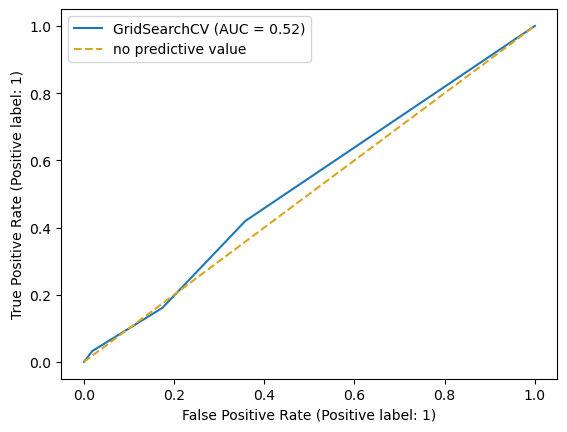

In [73]:
# most current method in scikit-learn is RocCurveDisplay
# Nope
RocCurveDisplay.from_estimator(gs, X_test, y_test)

#'worst case scenario' line
plt.plot([0,1], [0,1],
         label = 'no predictive value',
         linestyle = '--',
         color = 'goldenrod')

# add a legend
plt.legend();